In [24]:
# @title
import math
import re
import os
import random
import sys
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
import itertools
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import corpora
from gensim.models import LdaModel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Banana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Banana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

In [10]:
df = pd.read_csv('COVID19 Twitter/vaccination_all_tweets.csv')

In [11]:
df['date'] = pd.to_datetime(df['date']).dt.date #convert to just a date
df.set_index(['date', 'id'])

user_name  \
date       id                                          
2020-12-20 1340539111971516416            Rachel Roh   
2020-12-13 1338158543359250433           Albert Fong   
2020-12-12 1337858199140118533              eli🇱🇹🇪🇺👌   
           1337855739918835717         Charles Adler   
           1337854064604966912  Citizen News Channel   
...                                              ...   
2021-11-15 1460170772299665408                VaxBLR   
           1460163268262051841                VaxBLR   
           1460163224221851655                VaxBLR   
           1460156376995573765      Gatti Valentino🐾   
           1460155671140134912                VaxBLR   

                                            user_location  \
date       id                                               
2020-12-20 1340539111971516416  La Crescenta-Montrose, CA   
2020-12-13 1338158543359250433          San Francisco, CA   
2020-12-12 1337858199140118533                   Your Bed   
           1337855739918835717     Vancouver, BC - Canada   
           1337854064604966912                        NaN   
...                                                   ...   
2021-11-15 1460170772299665408           Bengaluru, India   
           1460163268262051841           Bengaluru, India   
           1460163224221851655           Bengaluru, India   
           1460156376995573765          Southern  Africa    
           1460155671140134912           Bengaluru, India   

                                                                 user_description  \
date       id                                                                       
2020-12-20 1340539111971516416  Aggregator of Asian American news; scanning di...   
2020-12-13 1338158543359250433  Marketing dude, tech geek, heavy metal & '80s ...   
2020-12-12 1337858199140118533                                     heil, hydra 🖐☺   
           1337855739918835717  Hosting "CharlesAdlerTonight" Global News Radi...   
           1337854064604966912  Citizen News Channel bringing you an alternati...   
...                                                                           ...   
2021-11-15 1460170772299665408  Hourly updates on FREE and PAID 18+ and 45+ va...   
           1460163268262051841  Hourly updates on FREE and PAID 18+ and 45+ va...   
           1460163224221851655  Hourly updates on FREE and PAID 18+ and 45+ va...   
           1460156376995573765  Entrepreneur, self taught cook🍲🌮 @Chelsea @Fer...   
           1460155671140134912  Hourly updates on FREE and PAID 18+ and 45+ va...   

                                       user_created  user_followers  \
date       id                                                         
2020-12-20 1340539111971516416  2009-04-08 17:52:46             405   
2020-12-13 1338158543359250433  2009-09-21 15:27:30             834   
2020-12-12 1337858199140118533  2020-06-25 23:30:28              10   
           1337855739918835717  2008-09-10 11:28:53           49165   
           1337854064604966912  2020-04-23 17:58:42             152   
...                                             ...             ...   
2021-11-15 1460170772299665408  2021-06-21 08:44:34              31   
           1460163268262051841  2021-06-21 08:44:34              31   
           1460163224221851655  2021-06-21 08:44:34              31   
           1460156376995573765  2019-08-28 10:31:43            8103   
           1460155671140134912  2021-06-21 08:44:34              31   

                                user_friends  user_favourites  user_verified  \
date       id                                                                  
2020-12-20 1340539111971516416          1692             3247          False   
2020-12-13 1338158543359250433           666              178          False   
2020-12-12 1337858199140118533            88              155          False   
           1337855739918835717          3933            21853           True   
          

In [12]:
df_copy = df[df['user_verified'] == True]
df_copy = df[~df['user_location'].isnull() & ~df['hashtags'].isnull()]

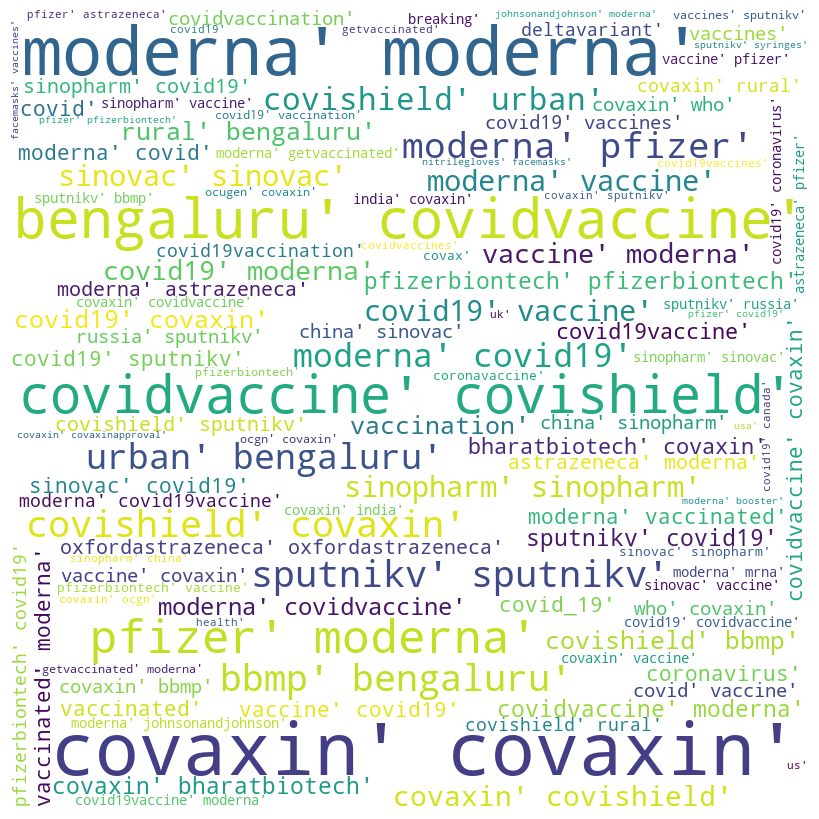

In [14]:
# @title
#word cloud
from wordcloud import WordCloud, STOPWORDS

# create a list of comment words
comment_words = ''

stopwords = set(STOPWORDS)

for val in df_copy.hashtags:
    val = str(val)
    tokens = val.split()

    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += ' '.join(tokens) + ' '

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [15]:
# define bag of words algorithm
# https://builtin.com/machine-learning/bag-of-words
def get_bag_of_words(doc, vocab):
   # Create initial dictionary which maps each vocabulary word to a count of 0
   word_count_dict = {word: 0 for word in vocab}
   # For each word in the doc, increment its count
   for word in doc:
      if word in vocab:
       word_count_dict[word] += 1

   # Now, initialize the vector to a list of zeros
   bag = [word_count_dict[word] for word in vocab]
   new_dict = dict(zip(vocab, bag))
   return new_dict

In [20]:
# use BOW algorith to filter out corporate and automated tweets
# resource used: https://sproutsocial.com/insights/what-to-tweet/
corp_vocab = [
    "excited", "new", "launch", "exclusive", "limited-time", "innovation", "customer-centric", "solution", "trending", "giveaway", "ask us", "join the conversation", "share your thoughts", "proud to announce", "important update", "learn more", "click here", "retweet", "like", "follow", "subscribe"
]

doc = df['text'].to_string()
# Split on all non-alphanumeric characters (i.e., whitespace and punctuation)
doc = re.split(r"\W", doc)
# Drop empty strings that arise from splitting
doc = [s for s in doc if len(s) > 0]

words_to_filter = get_bag_of_words(doc, corp_vocab)

In [21]:
filtered_df = df[~df['text'].str.contains('|'.join(words_to_filter.keys()))]

In [22]:
# LDA to find popular words/topics in remaining tweets
n_iters = 10
n_documents = len(filtered_df['id'])
n_topics = 5
eta = 3
alpha = 2

In [ ]:
word_list = []
for text in filtered_df.text:
  words = nltk.word_tokenize(text.lower())
  words = [word for word in words if word not in stopwords.words('english') and word.isalnum() and len(word)>=2]
  word_list.append(words)

dictionary = corpora.Dictionary(words_list)
corpus = [dictionary.doc2bow(text) for text in word_list]
lda = LdaModel(corpus, id2word=dictionary, num_topics=n_topics, passes=n_iters, alpha=alpha, eta=eta)

In [ ]:
# Create an instance of SentimentIntensityAnalyzer
model = SentimentIntensityAnalyzer()

## The result from the VADER model is a set of four different numbers that belong to classes such as negative, neutral, positive, and compound. The break up of the score for these classes is as follows:

 - Negative: It depicts the negative sentiment and its value ranges from 0 to 1.
 - Neutral: It depicts the neutral sentiment and its value ranges from 0 to 1.
 - Positive: It depicts the positive sentiment and its value ranges from 0 to 1.
 - Compound: It provides us the overall sentiment score and its value ranges from -1 to 1, -1 being the strong negative sentiment and 1 being the strong positive sentiment.

In [ ]:
def extract_scor(text):
    score = model.polarity_scores(text)
    compound = score['compound']

    sentinment = 'neutral'
    
    if (compound>=0.05):
        sentiment="positive"
    elif (compound>=0.05):
        sentiment="negative"

    return sentinment